In [ ]:
!pip install --upgrade python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=d4176d0c0210c6bee29647ac9b3d915d18b6f26e77c6500f86e8a2ff988b1701
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [ ]:
!apt-get install stockfish

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  polyglot xboard | scid
The following NEW packages will be installed:
  stockfish
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 24.8 MB of archives.
After this operation, 47.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 stockfish amd64 14.1-1 [24.8 MB]
Fetched 24.8 MB in 4s (6,012 kB/s)
Selecting previously unselected package stockfish.
(Reading database ... 123624 files and directories currently installed.)
Preparing to unpack .../stockfish_14.1-1_amd64.deb ...
Unpacking stockfish (14.1-1) ...
Setting up stockfish (14.1-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
import chess
import chess.pgn
import numpy as np
import math
from tqdm import tqdm
import random
import multiprocessing as mp
import concurrent.futures
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from chess import Move
import torch.multiprocessing as mp
from functools import partial
from collections import deque
from concurrent.futures import ThreadPoolExecutor
import threading
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

In [ ]:
root = "/content/drive/MyDrive/RL_chess/"

In [ ]:
class ChessEnvironment:
    def __init__(self):
        self.board = chess.Board()

    def reset(self):
        """Reset the board to the starting position."""
        self.board.reset()
        return self._get_state()

    def step(self, action):
        """
        Apply the given move and return the new state, reward, and whether the game is done.

        Args:
        action (chess.Move): The move to apply

        Returns:
        tuple: (state, reward, done, info)
        """
        if type(action) == str:
           action = chess.Move.from_uci(action)
        if action not in self.board.legal_moves:
            raise ValueError("Illegal move")

        self.board.push(action)

        done = self.board.is_game_over()
        reward = self._get_reward()
        state = self._get_state()
        info = self._get_game_info()

        return state, reward, done, info

    def get_legal_moves(self):
        """Return a list of legal moves in the current position."""
        return list(self.board.legal_moves)

    def _get_state(self):
        """
        Convert the current board state to a format suitable for the neural network.

        Returns:
        numpy.array: An 8x8x12 binary tensor representing the board state
        """
        import numpy as np

        state = np.zeros((8, 8, 12), dtype=np.float32)

        piece_types = [chess.PAWN, chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN, chess.KING]

        for i in range(64):
            piece = self.board.piece_at(i)
            if piece:
                color = int(piece.color)
                piece_type = piece_types.index(piece.piece_type)
                state[i // 8, i % 8, piece_type + 6*color] = 1

        return state

    def _get_reward(self):
        if self.board.is_game_over():
            result = self.board.result()
            if result == '1-0':
                return 1 if self.board.turn == chess.WHITE else -1
            elif result == '0-1':
                return -1 if self.board.turn == chess.WHITE else 1
            else:
                return 0  # Draw
        else:
            return 0  # Ongoing game


    def _get_game_info(self):
        """
        Get detailed information about the current game state.

        Returns:
        dict: Information about the game state
        """
        info = {
            'is_check': self.board.is_check(),
            'is_checkmate': self.board.is_checkmate(),
            'is_stalemate': self.board.is_stalemate(),
            'is_insufficient_material': self.board.is_insufficient_material(),
            'is_fifty_moves': self.board.is_fifty_moves(),
            'is_repetition': self.board.is_repetition(),
            'fullmove_number': self.board.fullmove_number,
            'halfmove_clock': self.board.halfmove_clock,
            'turn': 'White' if self.board.turn == chess.WHITE else 'Black'
        }
        return info

    def copy(self):
        """Create a deep copy of the environment."""
        new_env = ChessEnvironment()
        new_env.board = self.board.copy()
        return new_env

    def render(self):
        """Display the current state of the board."""
        print(self.board)

    def is_game_over(self):
        """Check if the game has ended."""
        return self.board.is_game_over()

    def get_board(self):
        return self.board

    def get_board_from_state(self, state):
        """
        Recreate the chess board from the state tensor.

        Args:
        state (numpy.array): An 8x8x12 binary tensor representing the board state

        Returns:
        chess.Board: A board object representing the current state
        """
        new_board = chess.Board.empty()  # Create an empty board

        piece_types = [chess.PAWN, chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN, chess.KING]

        for i in range(64):
            row, col = divmod(i, 8)
            for j in range(12):
                if state[row, col, j] == 1:
                    piece_type = piece_types[j % 6]
                    color = chess.WHITE if j < 6 else chess.BLACK
                    square = chess.square(col, 7 - row)  # Board indexing is flipped
                    new_board.set_piece_at(square, chess.Piece(piece_type, color))
                    break

        return new_board


In [ ]:
class ChessConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))

class ChessResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)

class ChessNetwork(nn.Module):
    def __init__(self, num_res_blocks=19, num_channels=256, num_moves=4672):
        super().__init__()

        # Input layer - Corregido: 12 canales de entrada, num_channels de salida
        self.conv_input = ChessConvBlock(12, num_channels)  # Cambiado de (num_channels, 12) a (12, num_channels)

        # Residual tower
        self.res_tower = nn.Sequential(
            *[ChessResidualBlock(num_channels) for _ in range(num_res_blocks)]
        )

        # El resto permanece igual...
        self.policy_conv = nn.Conv2d(num_channels, 32, kernel_size=3, padding=1)
        self.policy_bn = nn.BatchNorm2d(32)
        self.policy_fc = nn.Linear(32 * 8 * 8, num_moves)

        self.value_conv = nn.Conv2d(num_channels, 32, kernel_size=3, padding=1)
        self.value_bn = nn.BatchNorm2d(32)
        self.value_fc1 = nn.Linear(32 * 8 * 8, 256)
        self.value_fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # x shape viene como: (batch_size, 8, 8, 12)
        # Necesitamos convertirlo a: (batch_size, 12, 8, 8)
        x = x.permute(0, 3, 1, 2)  # Reorganiza las dimensiones

        x = self.conv_input(x)
        x = self.res_tower(x)

        # Policy head
        policy = F.relu(self.policy_bn(self.policy_conv(x)))
        policy = policy.reshape(policy.size(0), -1)
        policy = self.policy_fc(policy)

        # Value head
        value = F.relu(self.value_bn(self.value_conv(x)))
        value = value.reshape(value.size(0), -1)
        value = F.relu(self.value_fc1(value))
        value = torch.tanh(self.value_fc2(value))

        return policy, value

In [ ]:
def move_to_index(move, board):
    """
    Convert a chess.Move to a unique index in the range 0-4671.

    Args:
        move (chess.Move): The move to convert.
        board (chess.Board): The current board.

    Returns:
        int: The unique index of the move.

    Raises:
        ValueError: If the move is illegal or the index is out of bounds.
    """
    if type(move) == str:
        move = chess.Move.from_uci(move)
    from_square = move.from_square
    to_square = move.to_square

    NORMAL_MOVE_START = 0
    PROMOTION_MOVE_START = 4096
    CASTLING_MOVE_START = 4352
    EN_PASSANT_MOVE_START = 4356

    if board.is_castling(move):
        castling_map = {
            chess.Move.from_uci("e1g1"): 0,  # White kingside
            chess.Move.from_uci("e1c1"): 1,  # White queenside
            chess.Move.from_uci("e8g8"): 2,  # Black kingside
            chess.Move.from_uci("e8c8"): 3,  # Black queenside
        }
        castling_index = castling_map.get(move, -1)

        if castling_index == -1:
            raise ValueError(f"Invalid castling move: {move}")
        index = CASTLING_MOVE_START + castling_index
        return index

    if board.is_en_passant(move):
        capture_file = chess.square_file(move.to_square)
        if board.turn == chess.WHITE:
            # White en passant captures
            index = EN_PASSANT_MOVE_START + capture_file  # 4356 + file (0-7)
        else:
            # Black en passant captures
            index = EN_PASSANT_MOVE_START + 8 + capture_file  # 4364 + file (0-7)
        if index >= 4372:
            raise ValueError(f"En passant index out of bounds: {index}")
        return index

    if move.promotion:
        promotion_map = {
            chess.QUEEN: 0,
            chess.ROOK: 1,
            chess.BISHOP: 2,
            chess.KNIGHT: 3
        }
        promotion_type = promotion_map.get(move.promotion, None)
        if promotion_type is None:
            raise ValueError(f"Unsupported promotion type: {move.promotion}")
        # Each from_square can have up to 4 promotion types
        promotion_index = PROMOTION_MOVE_START + (from_square * 4) + promotion_type
        if promotion_index >= CASTLING_MOVE_START:
            raise ValueError(f"Promotion index out of bounds: {promotion_index}")
        return promotion_index

    # Normal move
    normal_move_index = NORMAL_MOVE_START + (from_square * 64) + to_square
    if normal_move_index >= PROMOTION_MOVE_START:
        raise ValueError(f"Normal move index out of bounds: {normal_move_index}")
    return normal_move_index


In [ ]:
def index_to_move(index, board):
    """
    Convert a unique index back to a chess.Move.

    Args:
        index (int): The index of the move (0-4671).
        board (chess.Board): The current board.

    Returns:
        chess.Move: The corresponding chess.Move.

    Raises:
        ValueError: If the index is out of bounds or does not correspond to a valid move.
    """
    NORMAL_MOVE_START = 0
    PROMOTION_MOVE_START = 4096
    CASTLING_MOVE_START = 4352
    EN_PASSANT_MOVE_START = 4356

    if NORMAL_MOVE_START <= index < PROMOTION_MOVE_START:
        # Normal move
        move_num = index - NORMAL_MOVE_START
        from_square = move_num // 64
        to_square = move_num % 64
        move = chess.Move(from_square, to_square)
        if move not in board.legal_moves:
            raise ValueError(f"Invalid normal move for index {index}: {move}")
        return move

    elif PROMOTION_MOVE_START <= index < CASTLING_MOVE_START:
        # Promotion move
        move_num = index - PROMOTION_MOVE_START
        from_square = move_num // 4
        promotion_type = move_num % 4
        promotion_map = {0: chess.QUEEN, 1: chess.ROOK, 2: chess.BISHOP, 3: chess.KNIGHT}
        promotion_piece = promotion_map.get(promotion_type, chess.QUEEN)

        # Determine the to_square based on the board and promotion
        if board.turn == chess.WHITE:
            to_square = from_square + 8  # Move to the 8th rank
        else:
            to_square = from_square - 8  # Move to the 1st rank

        move = chess.Move(from_square, to_square, promotion=promotion_piece)
        if move not in board.legal_moves:
            raise ValueError(f"Invalid promotion move for index {index}: {move}")
        return move

    elif CASTLING_MOVE_START <= index < EN_PASSANT_MOVE_START:
        # Castling move
        castling_map_reverse = {
            4352: chess.Move.from_uci("e1g1"),  # White kingside
            4353: chess.Move.from_uci("e1c1"),  # White queenside
            4354: chess.Move.from_uci("e8g8"),  # Black kingside
            4355: chess.Move.from_uci("e8c8"),  # Black queenside
        }
        move = castling_map_reverse.get(index, None)
        if move is None or move not in board.legal_moves:
            raise ValueError(f"Invalid castling move for index {index}")
        return move

    elif EN_PASSANT_MOVE_START <= index < 4672:
        # En passant move
        move_num = index - EN_PASSANT_MOVE_START
        from_square = move_num // 8
        to_file = move_num % 8

        # Determine to_square based on from_square and player color
        from_rank = chess.square_rank(from_square)
        if board.turn == chess.WHITE:
            to_rank = from_rank + 1
        else:
            to_rank = from_rank - 1

        to_square = chess.square(to_file, to_rank)
        move = chess.Move(from_square, to_square, chess.Move.EN_PASSANT)
        if move not in board.legal_moves:
            raise ValueError(f"Invalid en passant move for index {index}: {move}")
        return move

    else:
        raise ValueError(f"Move index out of bounds: {index}")


In [ ]:
class MCTSNode:
    def __init__(self, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.action = action
        self.children = {}
        self.visit_count = 0
        self.value_sum = 0
        self.prior = 0

    def expand(self, policy):
        for action in self.state.get_legal_moves():
            if str(action) not in self.children:
                new_state = self.state.copy()
                new_state.step(action)
                self.children[str(action)] = MCTSNode(new_state, parent=self, action=action)
                self.children[str(action)].prior = policy[move_to_index(action, self.state.get_board())]

    def select_child(self, c_puct=1.0):
        """
        Selecciona el mejor hijo basándose en el puntaje UCB.
        """
        best_score = -float('inf')
        best_child = None
        for child in self.children.values():
            ucb_score = child.get_ucb_score(c_puct)
            if ucb_score > best_score:
                best_score = ucb_score
                best_child = child
        return best_child

    def get_ucb_score(self, c_puct):
        u = (c_puct * self.prior * math.sqrt(self.parent.visit_count) /
             (1 + self.visit_count))
        q = self.value_sum / self.visit_count if self.visit_count > 0 else 0
        return q + u

    def update(self, value):
        self.visit_count += 1
        self.value_sum += value

    def is_leaf(self):
        return len(self.children) == 0

    def is_root(self):
        return self.parent is None

In [ ]:
class AlphaZeroTrainer:
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4)
        self.mcts_simulations = 50
        self.temperature = 1.0
        self.memory = deque(maxlen=10000)  # Reducido el tamaño del buffer
        self.batch_ready = threading.Event()
        self.training_batch = []

        self.policy_loss_history = []
        self.value_loss_history = []
        self.total_loss_history = []

    def run_mcts_parallel(self, env_list):
        """Ejecuta MCTS en paralelo para múltiples estados"""
        roots = [MCTSNode(env) for env in env_list]

        with ThreadPoolExecutor(max_workers=4) as executor:
            futures = []
            for root in roots:
                futures.append(executor.submit(self._run_single_mcts, root))

            results = [future.result() for future in futures]

        return results

    def get_action_prob(self, root, temperature=1.0):
        visits = np.zeros(4672)
        actions = list(root.children.keys())
        visit_counts = np.array([child.visit_count for child in root.children.values()])

        # Normalizar las visitas según la temperatura
        if temperature == 0:
            visit_counts = np.zeros_like(visit_counts)
            best_move = np.argmax(visit_counts)
            visit_counts[best_move] = 1
        else:
            # Evitar división por cero
            if np.sum(visit_counts) == 0:
                visit_counts = np.ones_like(visit_counts) / len(visit_counts)
            else:
                visit_counts = visit_counts ** (1.0 / temperature)
                visit_counts = visit_counts / np.sum(visit_counts)

        # Convertir las acciones a índices y llenar el vector de probabilidades
        for action, prob in zip(actions, visit_counts):
            if isinstance(action, str):
                move = chess.Move.from_uci(action)
            else:
                move = action
            move_idx = move_to_index(move, root.state.get_board())
            visits[move_idx] = prob

        return visits

    def _run_single_mcts(self, root):
        """Ejecuta MCTS para un solo estado"""
        for _ in range(self.mcts_simulations):
            node = root
            search_path = [node]

            while not node.is_leaf() and not node.state.is_game_over():
                node = node.select_child()
                search_path.append(node)

            if not node.state.is_game_over():
                state_tensor = torch.FloatTensor(node.state._get_state()).unsqueeze(0)
                state_tensor = state_tensor.to(self.device)

                with torch.no_grad():
                    policy, value = self.model(state_tensor)
                    policy = F.softmax(policy, dim=1).squeeze(0).cpu().numpy()

                node.expand(policy)
                value = value.item()
            else:
                value = node.state._get_reward()

            for node in reversed(search_path):
                node.update(-value)
                value = -value

        return root

    def self_play_game(self):
        env = ChessEnvironment()
        game_memory = []
        noise_added = False  # Bandera para controlar cuándo agregar ruido

        while not env.is_game_over():
            state = env._get_state()

            root = self._run_single_mcts(MCTSNode(env.copy()))

            # Obtener la política
            policy = self.get_action_prob(root, self.temperature)

            # Agregar ruido Dirichlet en los primeros N movimientos
            if not noise_added and len(game_memory) < 10:  # Por ejemplo, los primeros 10 movimientos
                epsilon = 0.25
                alpha = 1.0
                dirichlet_noise = np.random.dirichlet([alpha] * len(policy))
                policy = (1 - epsilon) * policy + epsilon * dirichlet_noise
                noise_added = True

            game_memory.append({
                'state': state,
                'policy': policy,
                'player': env.board.turn
            })

            # Select and make move
            legal_moves = env.get_legal_moves()
            legal_move_probs = np.array([policy[move_to_index(move, env.get_board())]
                                      for move in legal_moves])

            # Asegurar que las probabilidades sumen 1
            sum_probs = np.sum(legal_move_probs)
            if sum_probs > 0:
                legal_move_probs = legal_move_probs / sum_probs
            else:
                # Si todas las probabilidades son 0, usar distribución uniforme
                legal_move_probs = np.ones_like(legal_move_probs) / len(legal_move_probs)

            # Asegurar que no hay valores nan o inf
            legal_move_probs = np.nan_to_num(legal_move_probs, 0)

            # Renormalizar si es necesario
            sum_probs = np.sum(legal_move_probs)
            if sum_probs > 0:
                legal_move_probs = legal_move_probs / sum_probs
            else:
                legal_move_probs = np.ones_like(legal_move_probs) / len(legal_move_probs)

            try:
                move_idx = np.random.choice(len(legal_moves), p=legal_move_probs)
                action = legal_moves[move_idx]
            except ValueError as e:
                print(f"Error en probabilidades: {legal_move_probs}")
                print(f"Suma de probabilidades: {np.sum(legal_move_probs)}")
                # Fallback a selección aleatoria uniforme
                move_idx = np.random.randint(len(legal_moves))
                action = legal_moves[move_idx]

            env.step(action)

        print(env._get_game_info())

        value = env._get_reward()
        return [(data['state'], data['policy'],
            value if data['player'] else -value) for data in game_memory]

    def parallel_self_play(self, num_games):
        """Ejecuta múltiples juegos en paralelo"""
        with ThreadPoolExecutor(max_workers=4) as executor:
            futures = [executor.submit(self.self_play_game) for _ in range(num_games)]

            for future in futures:
                game_data = future.result()
                self.memory.extend(game_data)

    def train_epoch(self, batch_size=32):
        """Entrena la red por una época"""
        if len(self.memory) < batch_size:
            return 0, 0

        batch = random.sample(self.memory, batch_size)
        states, policies, values = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        policies = torch.FloatTensor(policies).to(self.device)
        values = torch.FloatTensor(values).to(self.device)

        self.optimizer.zero_grad()

        # Forward pass
        out_policies, out_values = self.model(states)

        # Calculate loss
        policy_loss = -torch.sum(policies * F.log_softmax(out_policies, dim=1), dim=1).mean()
        value_loss = F.mse_loss(out_values.squeeze(), values)
        total_loss = policy_loss + value_loss

        # Guardar pérdidas
        self.policy_loss_history.append(policy_loss.item())
        self.value_loss_history.append(value_loss.item())
        self.total_loss_history.append(total_loss.item())

        # Backward pass
        total_loss.backward()
        self.optimizer.step()

        return policy_loss.item(), value_loss.item()

def plot_training_losses(trainer, save_path=None):
    """
    Grafica las pérdidas del entrenamiento

    Args:
        trainer: Instancia de AlphaZeroTrainer
        save_path: Ruta donde guardar la gráfica (opcional)
    """
    plt.figure(figsize=(12, 8))

    # Crear subplots
    plt.subplot(3, 1, 1)
    plt.plot(trainer.policy_loss_history, label='Policy Loss', color='blue')
    plt.title('Training Losses Over Time')
    plt.ylabel('Policy Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(trainer.value_loss_history, label='Value Loss', color='red')
    plt.ylabel('Value Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(trainer.total_loss_history, label='Total Loss', color='purple')
    plt.xlabel('Training Steps')
    plt.ylabel('Total Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_moving_average_losses(trainer, window=100, save_path=None):
    """
    Grafica la media móvil de las pérdidas para suavizar las curvas

    Args:
        trainer: Instancia de AlphaZeroTrainer
        window: Tamaño de la ventana para la media móvil
        save_path: Ruta donde guardar la gráfica (opcional)
    """
    def moving_average(data, window):
        return np.convolve(data, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(12, 8))

    # Media móvil de las pérdidas
    ma_policy = moving_average(trainer.policy_loss_history, window)
    ma_value = moving_average(trainer.value_loss_history, window)
    ma_total = moving_average(trainer.total_loss_history, window)

    plt.plot(ma_policy, label=f'Policy Loss (MA-{window})', color='blue')
    plt.plot(ma_value, label=f'Value Loss (MA-{window})', color='red')
    plt.plot(ma_total, label=f'Total Loss (MA-{window})', color='purple')

    plt.title('Moving Average of Training Losses')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    if save_path:
        plt.savefig(save_path)
    plt.show()

def train_alphazero_optimized(model, num_iterations=5, games_per_iteration=4, epochs_per_iteration=5):
    """Versión optimizada del entrenamiento de AlphaZero con visualización de pérdidas"""
    trainer = AlphaZeroTrainer(model)

    for iteration in range(num_iterations):
        print(f"\nIteración {iteration + 1}/{num_iterations}")

        # Self-play en paralelo
        print("Generando juegos...")
        trainer.parallel_self_play(games_per_iteration)

        # Entrenamiento
        print("Entrenando...")
        for epoch in range(epochs_per_iteration):
            policy_loss, value_loss = trainer.train_epoch(batch_size=32)
            if epoch % 2 == 0:
                print(f"Época {epoch + 1}: Policy Loss = {policy_loss:.4f}, Value Loss = {value_loss:.4f}")

        # Guardar checkpoint y graficar pérdidas
        torch.save(model.state_dict(), root + f'models/chess_model_fast_weights_iter_{iteration}.pt')

        # Graficar y guardar las pérdidas cada iteración
        plot_training_losses(trainer, save_path=f'losses_iteration_{iteration}.png')
        plot_moving_average_losses(trainer, window=50, save_path=f'ma_losses_iteration_{iteration}.png')

        print(f"Checkpoint y gráficas guardadas para iteración {iteration}")

    # Graficar pérdidas finales
    plot_training_losses(trainer, save_path='final_losses.png')
    plot_moving_average_losses(trainer, window=50, save_path='final_ma_losses.png')

    return model


Iteración 1/7
Generando juegos...
{'is_check': True, 'is_checkmate': True, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': False, 'fullmove_number': 178, 'halfmove_clock': 8, 'turn': 'White'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_insufficient_material': True, 'is_fifty_moves': False, 'is_repetition': False, 'fullmove_number': 184, 'halfmove_clock': 0, 'turn': 'White'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': True, 'is_repetition': False, 'fullmove_number': 202, 'halfmove_clock': 150, 'turn': 'White'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_insufficient_material': True, 'is_fifty_moves': False, 'is_repetition': False, 'fullmove_number': 216, 'halfmove_clock': 0, 'turn': 'White'}
{'is_check': True, 'is_checkmate': True, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': Fal

<ipython-input-25-4d32eb7ae933>:172: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(states).to(self.device)


Época 1: Policy Loss = 8.3104, Value Loss = 0.1770
Época 3: Policy Loss = 8.2910, Value Loss = 0.9903
Época 5: Policy Loss = 7.8339, Value Loss = 1.1210
Época 7: Policy Loss = 7.8981, Value Loss = 1.0285
Época 9: Policy Loss = 7.5133, Value Loss = 0.8175
Época 11: Policy Loss = 7.6822, Value Loss = 0.6682
Época 13: Policy Loss = 7.5696, Value Loss = 0.5130
Época 15: Policy Loss = 7.5577, Value Loss = 0.4565
Época 17: Policy Loss = 7.2856, Value Loss = 0.3156
Época 19: Policy Loss = 6.9836, Value Loss = 0.3451
Época 21: Policy Loss = 7.1044, Value Loss = 0.2184
Época 23: Policy Loss = 7.4326, Value Loss = 0.4200
Época 25: Policy Loss = 7.3028, Value Loss = 0.2783
Época 27: Policy Loss = 7.0273, Value Loss = 0.3864
Época 29: Policy Loss = 7.0816, Value Loss = 0.1573
Época 31: Policy Loss = 7.2868, Value Loss = 0.1265
Época 33: Policy Loss = 7.1392, Value Loss = 0.3114
Época 35: Policy Loss = 6.9750, Value Loss = 0.4513
Época 37: Policy Loss = 6.7167, Value Loss = 0.3309
Época 39: Policy 

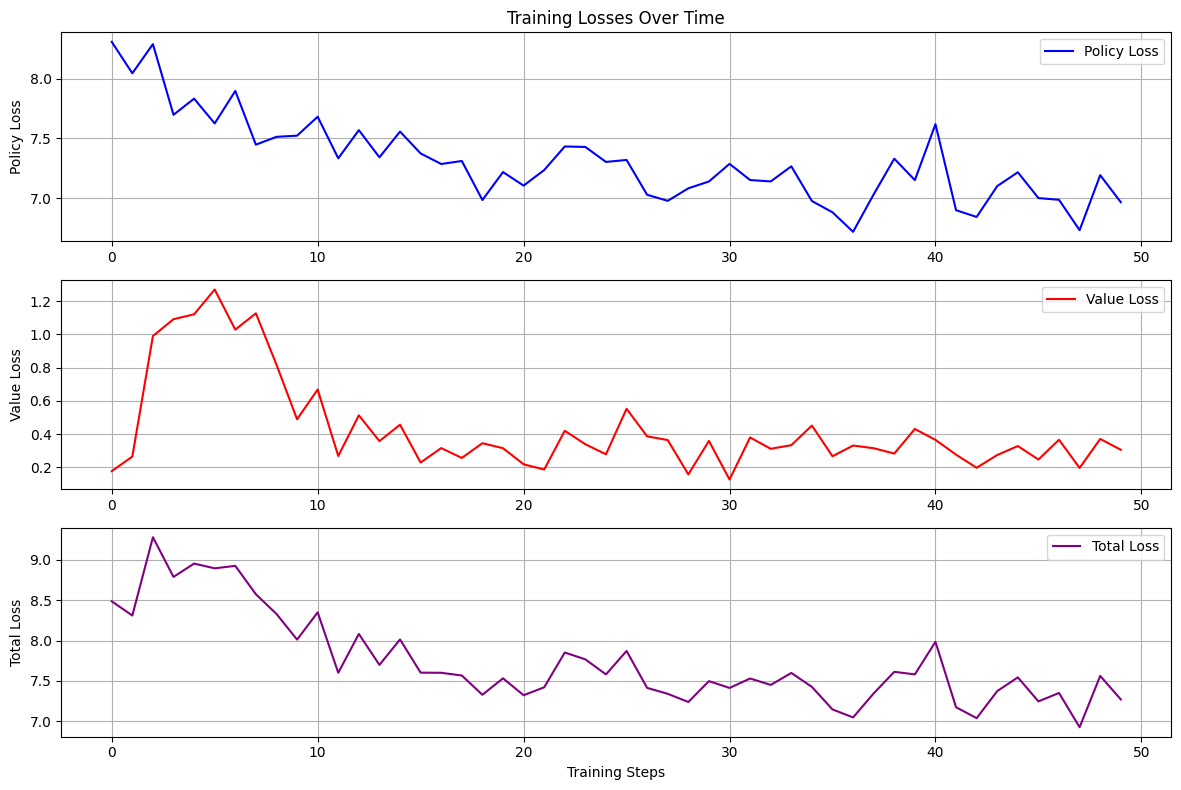

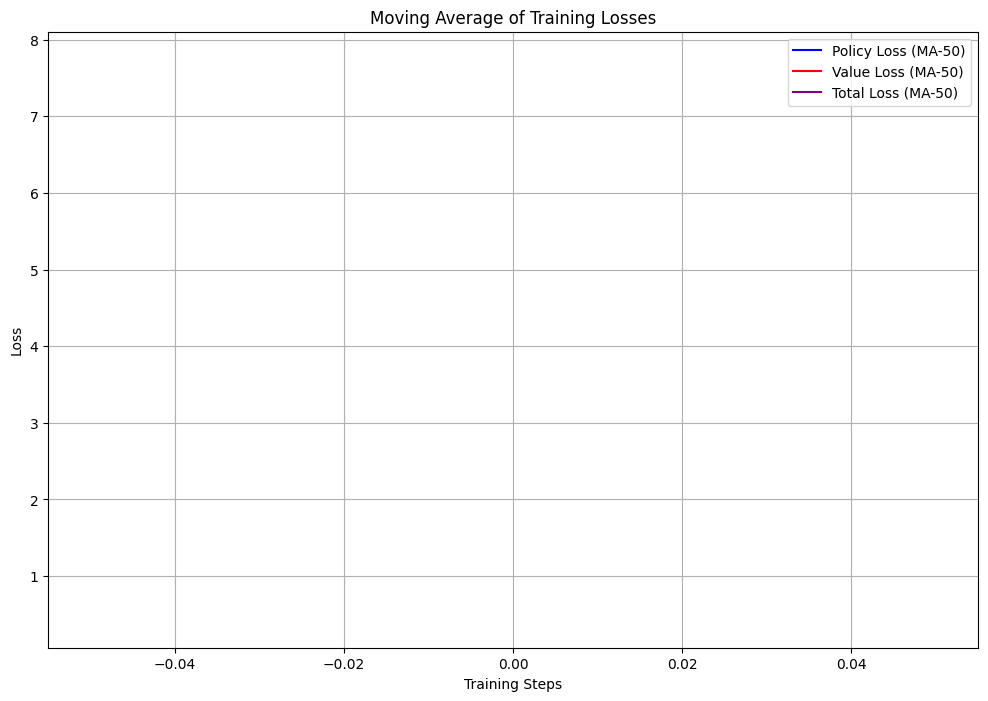

Checkpoint y gráficas guardadas para iteración 0

Iteración 2/7
Generando juegos...
{'is_check': True, 'is_checkmate': True, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': False, 'fullmove_number': 145, 'halfmove_clock': 9, 'turn': 'White'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': True, 'fullmove_number': 178, 'halfmove_clock': 20, 'turn': 'Black'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': True, 'fullmove_number': 196, 'halfmove_clock': 37, 'turn': 'Black'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': True, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': False, 'fullmove_number': 239, 'halfmove_clock': 34, 'turn': 'White'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_

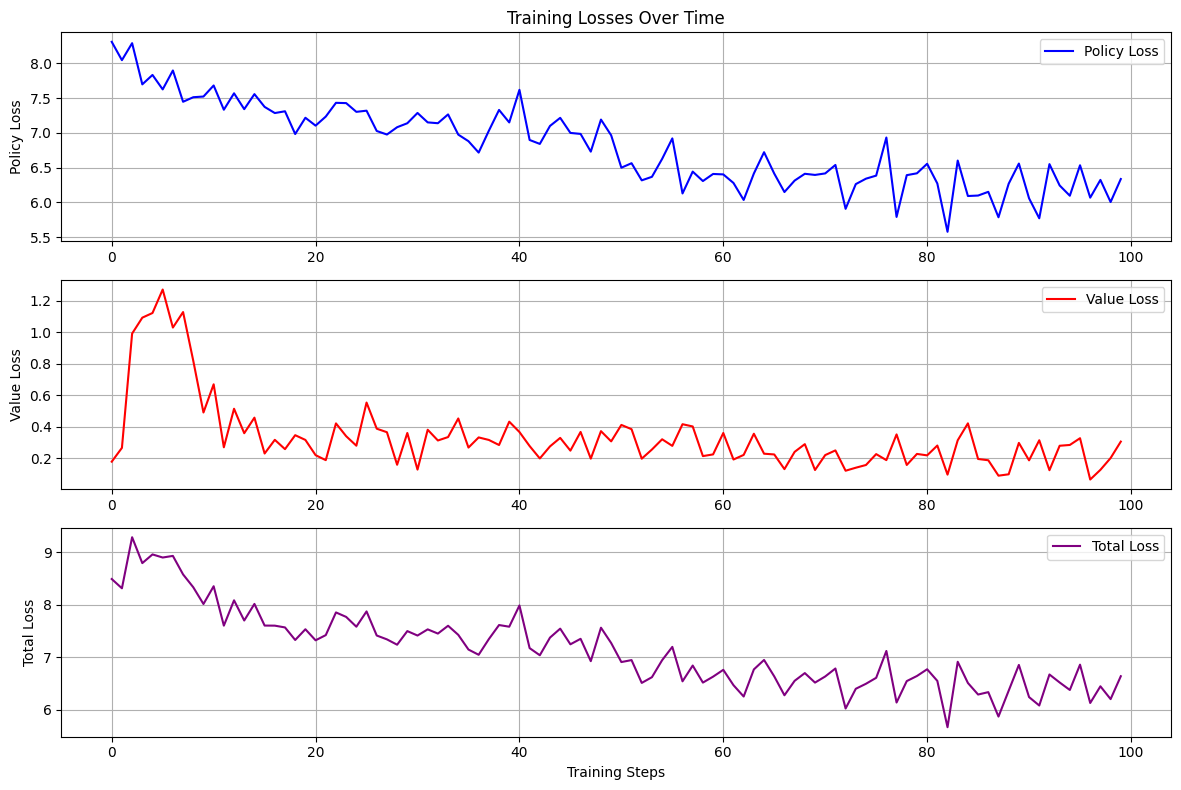

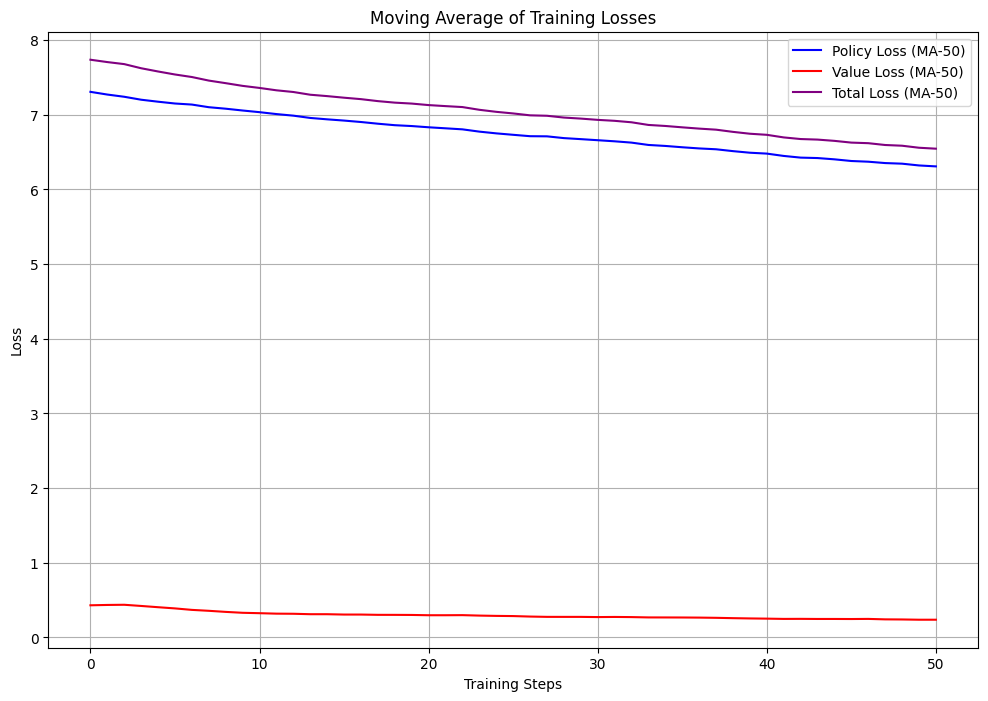

Checkpoint y gráficas guardadas para iteración 1

Iteración 3/7
Generando juegos...
{'is_check': False, 'is_checkmate': False, 'is_stalemate': True, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': False, 'fullmove_number': 87, 'halfmove_clock': 0, 'turn': 'White'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': True, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': False, 'fullmove_number': 129, 'halfmove_clock': 2, 'turn': 'White'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': True, 'fullmove_number': 145, 'halfmove_clock': 17, 'turn': 'Black'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': True, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': False, 'fullmove_number': 170, 'halfmove_clock': 0, 'turn': 'White'}
{'is_check': True, 'is_checkmate': True, 'is_stalemate': False, 'is_insu

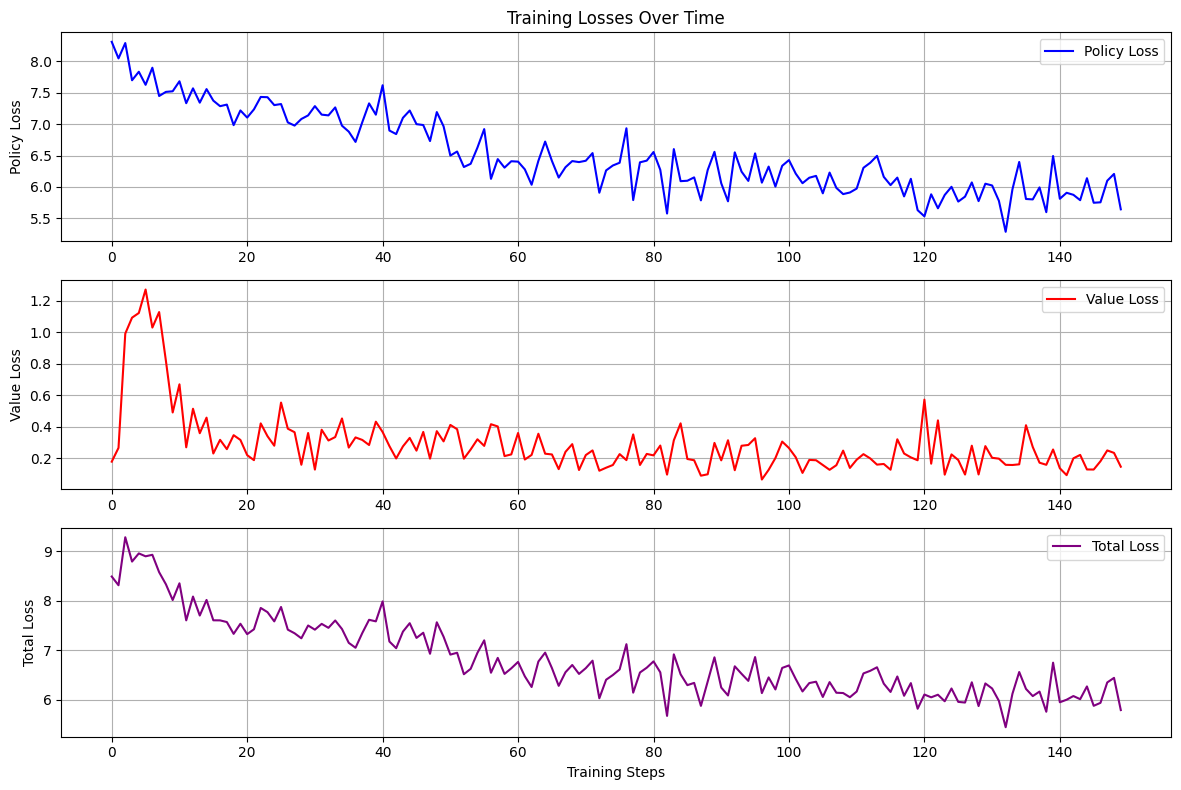

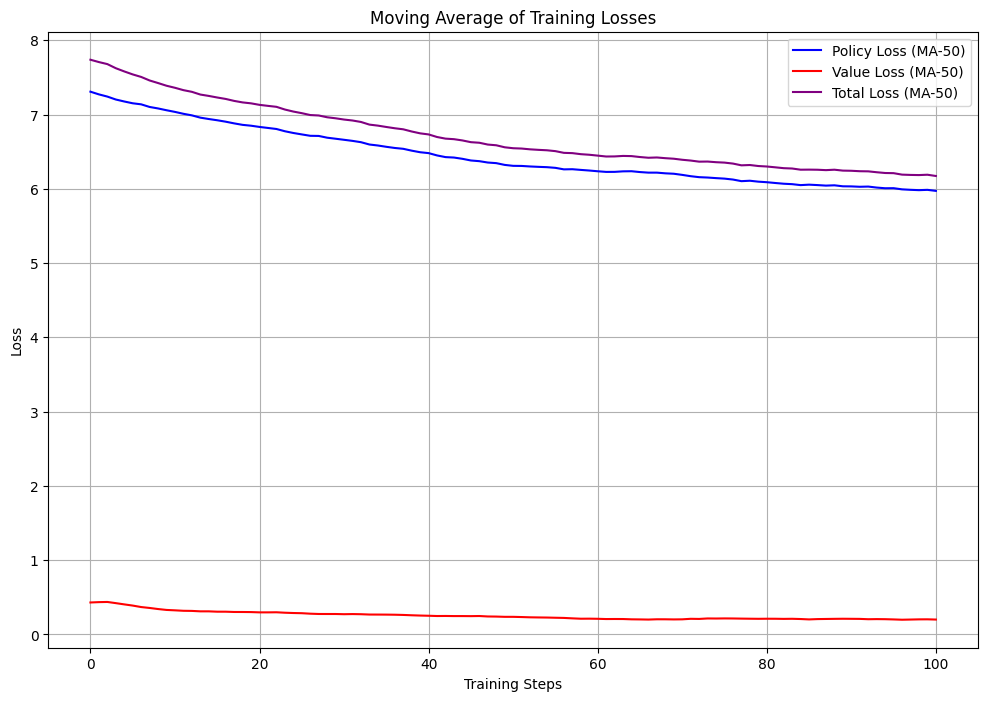

Checkpoint y gráficas guardadas para iteración 2

Iteración 4/7
Generando juegos...
{'is_check': True, 'is_checkmate': True, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': False, 'fullmove_number': 19, 'halfmove_clock': 0, 'turn': 'Black'}
{'is_check': True, 'is_checkmate': True, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': False, 'fullmove_number': 42, 'halfmove_clock': 1, 'turn': 'Black'}
{'is_check': True, 'is_checkmate': True, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': False, 'fullmove_number': 149, 'halfmove_clock': 15, 'turn': 'White'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_insufficient_material': True, 'is_fifty_moves': False, 'is_repetition': False, 'fullmove_number': 173, 'halfmove_clock': 0, 'turn': 'White'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_insuff

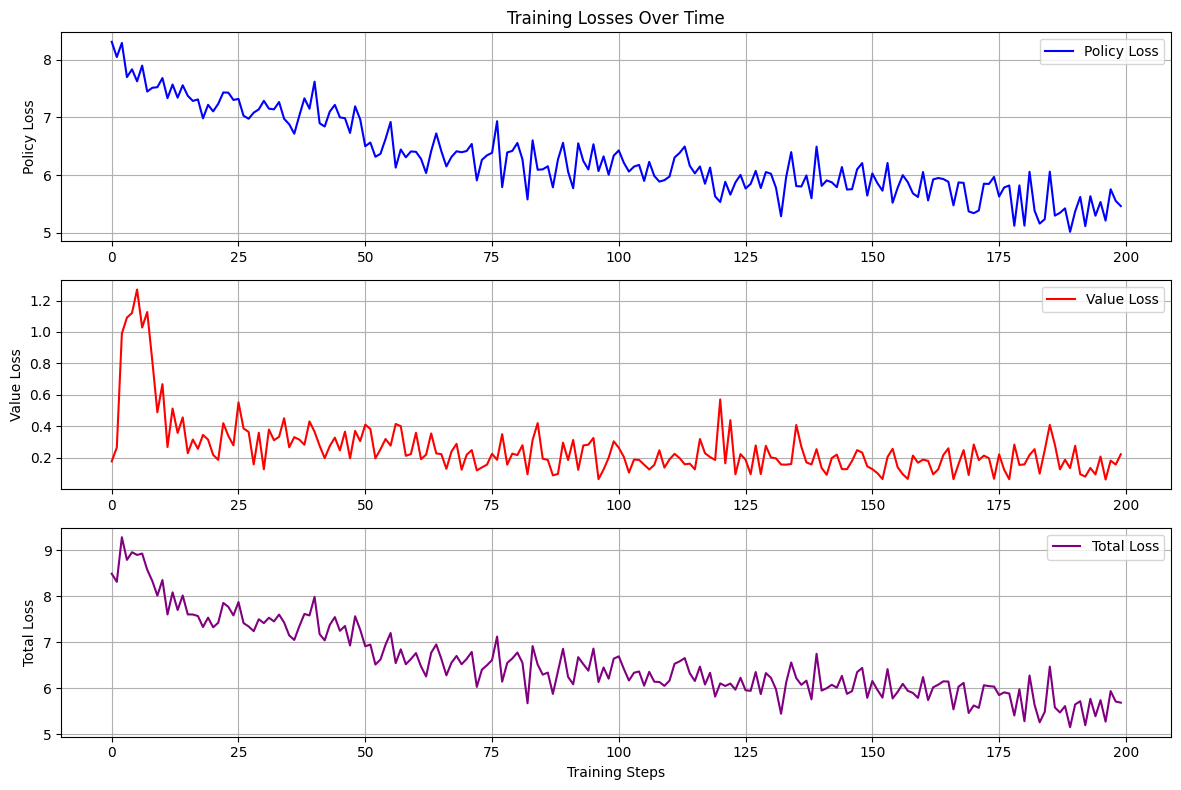

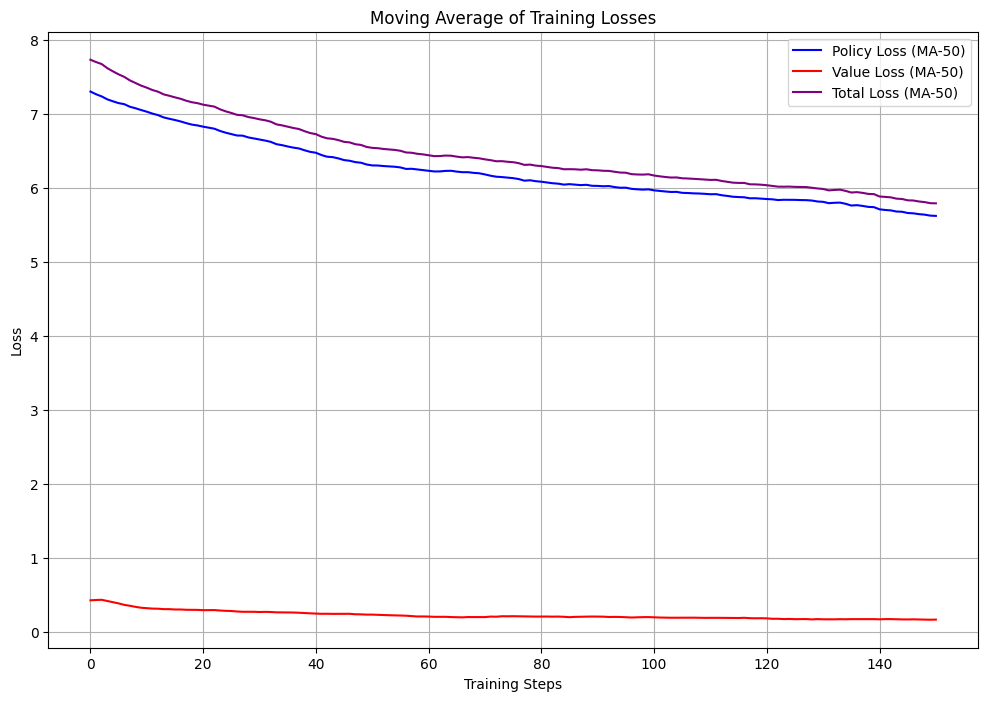

Checkpoint y gráficas guardadas para iteración 3

Iteración 5/7
Generando juegos...
{'is_check': True, 'is_checkmate': True, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': False, 'fullmove_number': 43, 'halfmove_clock': 1, 'turn': 'White'}
{'is_check': True, 'is_checkmate': True, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': False, 'fullmove_number': 102, 'halfmove_clock': 8, 'turn': 'White'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': True, 'fullmove_number': 122, 'halfmove_clock': 41, 'turn': 'White'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': True, 'fullmove_number': 107, 'halfmove_clock': 41, 'turn': 'White'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_ins

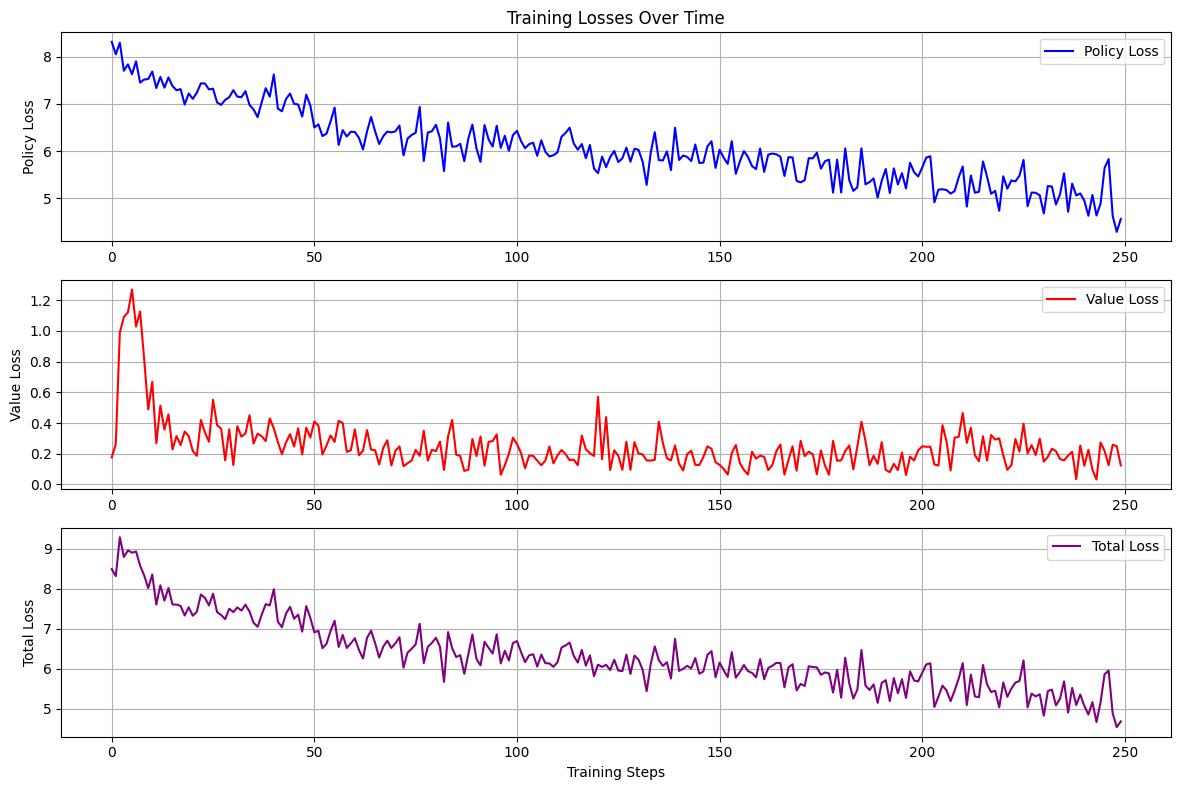

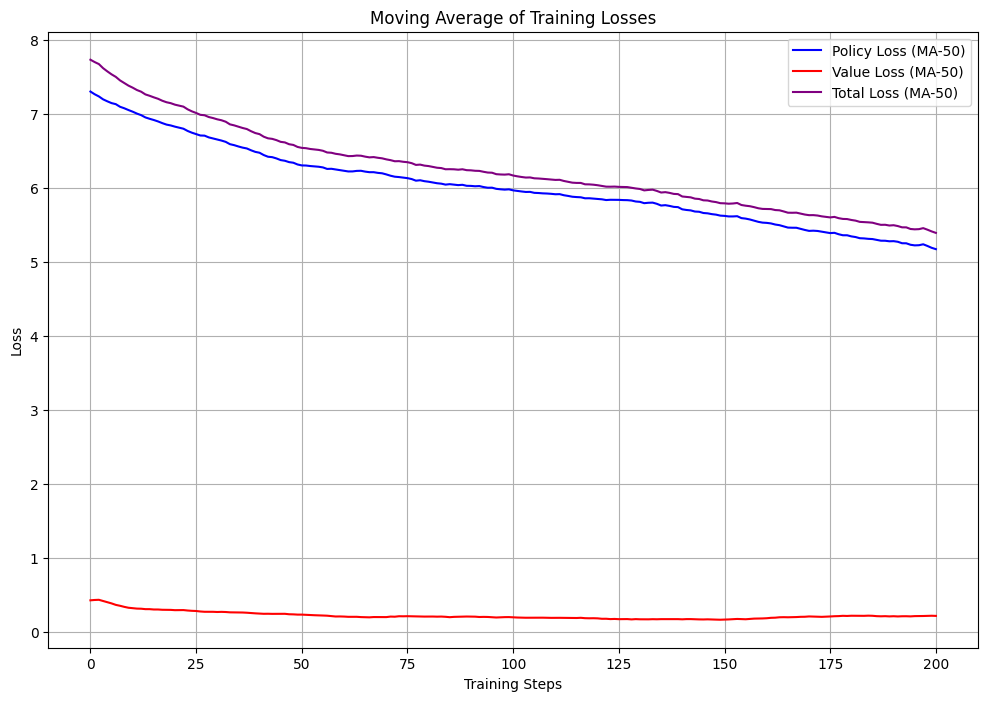

Checkpoint y gráficas guardadas para iteración 4

Iteración 6/7
Generando juegos...
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': True, 'fullmove_number': 73, 'halfmove_clock': 31, 'turn': 'White'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': True, 'fullmove_number': 102, 'halfmove_clock': 47, 'turn': 'White'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': True, 'fullmove_number': 69, 'halfmove_clock': 46, 'turn': 'Black'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': True, 'fullmove_number': 76, 'halfmove_clock': 21, 'turn': 'Black'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_i

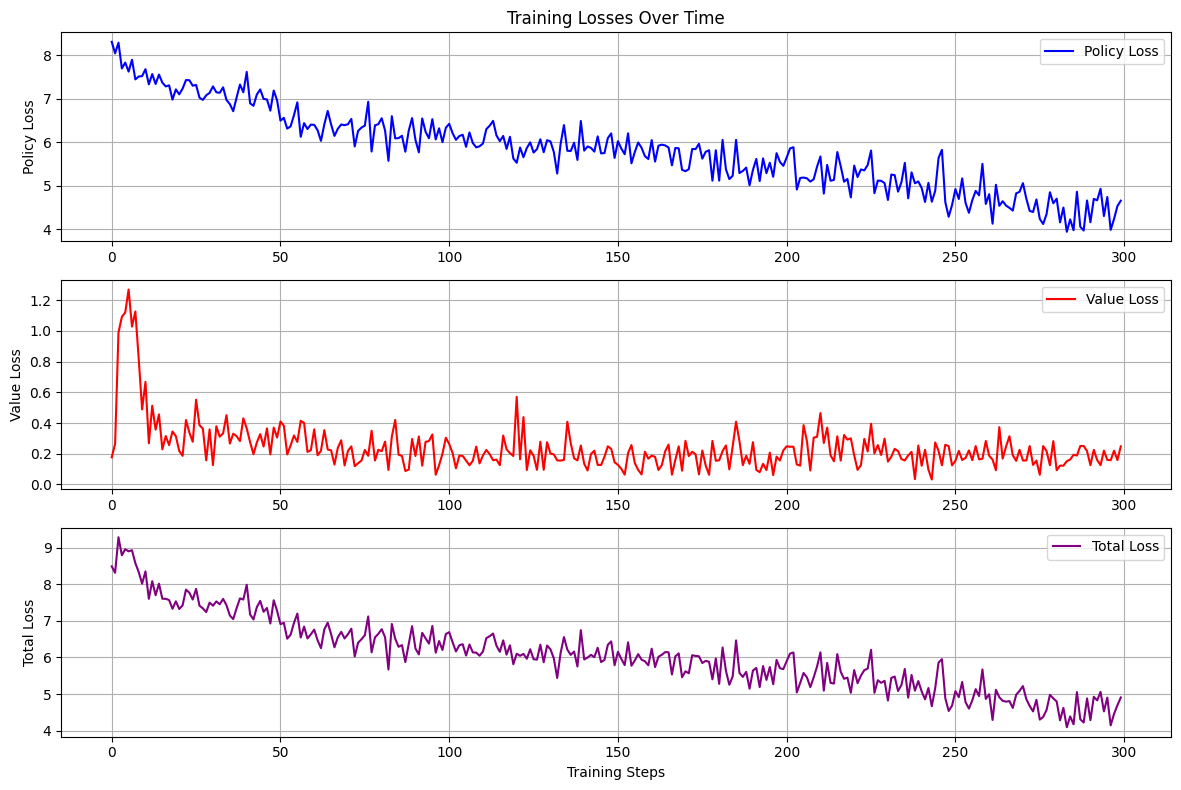

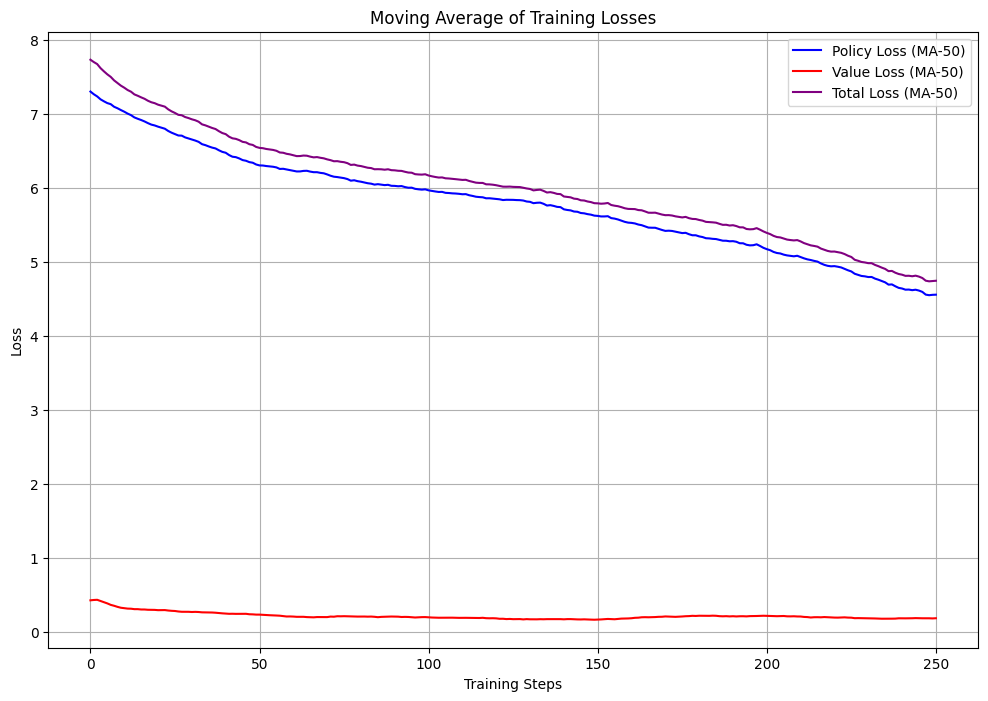

Checkpoint y gráficas guardadas para iteración 5

Iteración 7/7
Generando juegos...
{'is_check': True, 'is_checkmate': True, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': False, 'fullmove_number': 21, 'halfmove_clock': 1, 'turn': 'White'}
{'is_check': True, 'is_checkmate': True, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': False, 'fullmove_number': 67, 'halfmove_clock': 0, 'turn': 'Black'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': True, 'fullmove_number': 69, 'halfmove_clock': 44, 'turn': 'Black'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_insufficient_material': False, 'is_fifty_moves': False, 'is_repetition': True, 'fullmove_number': 94, 'halfmove_clock': 17, 'turn': 'Black'}
{'is_check': False, 'is_checkmate': False, 'is_stalemate': False, 'is_insuff

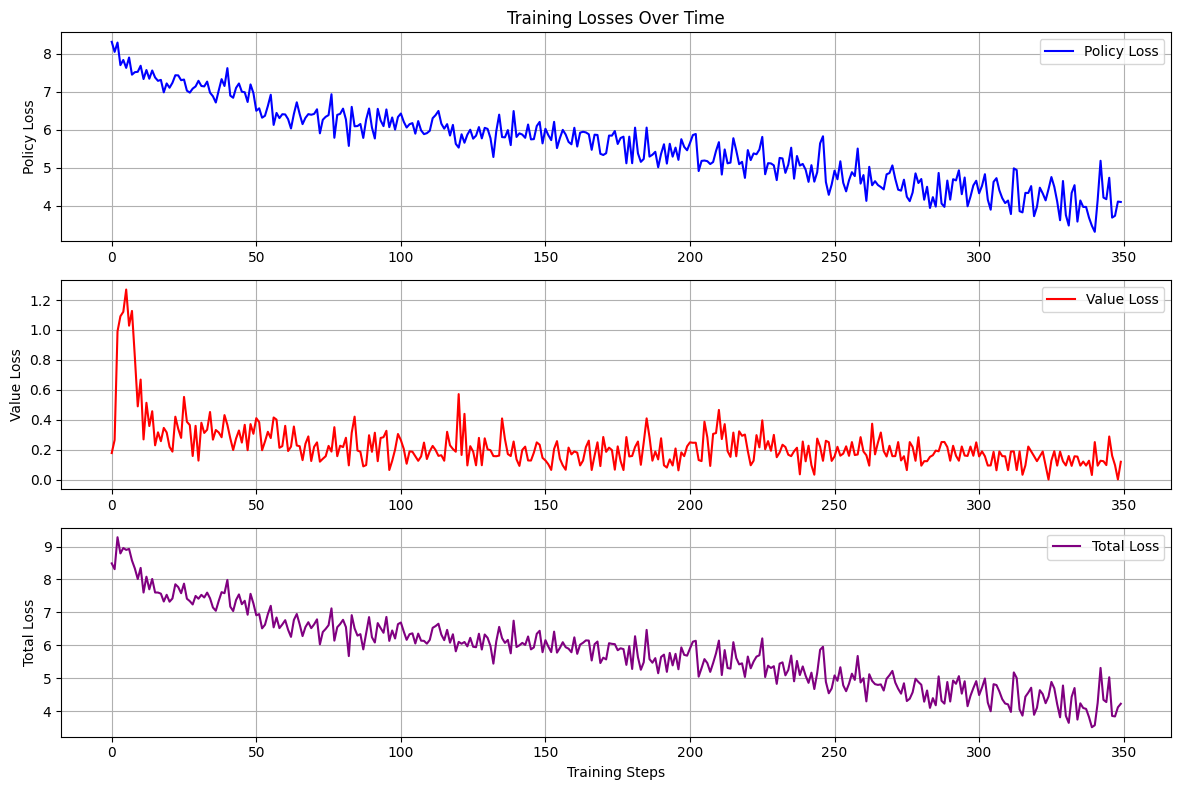

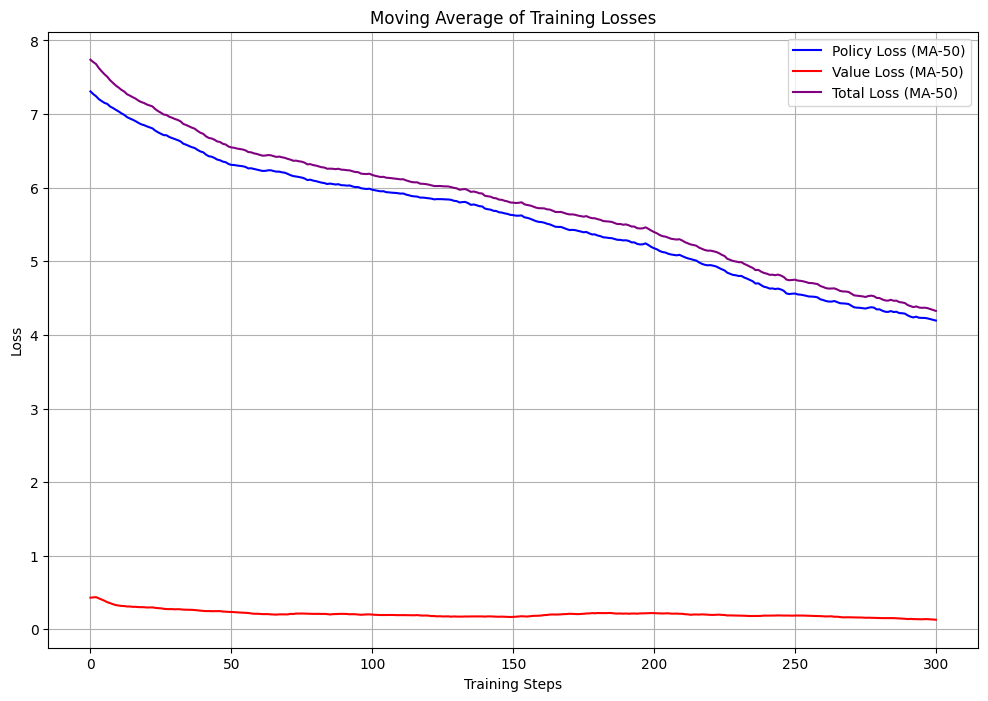

Checkpoint y gráficas guardadas para iteración 6


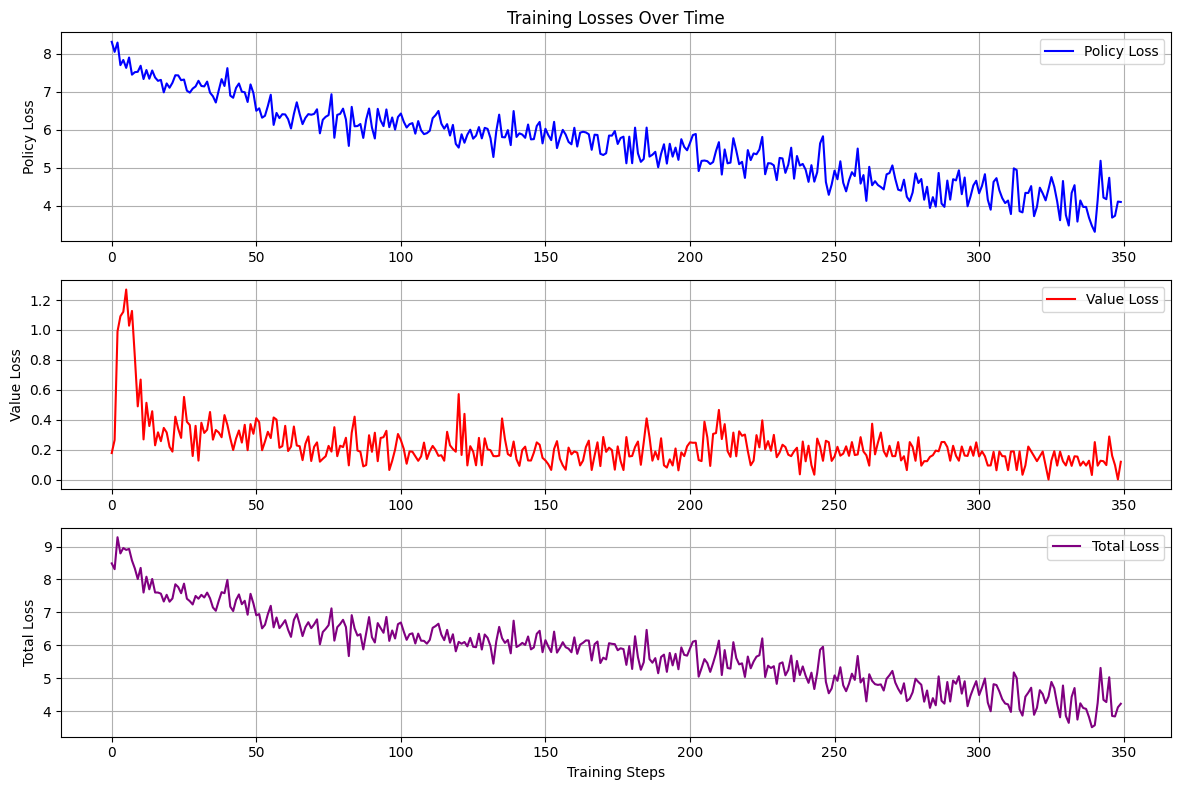

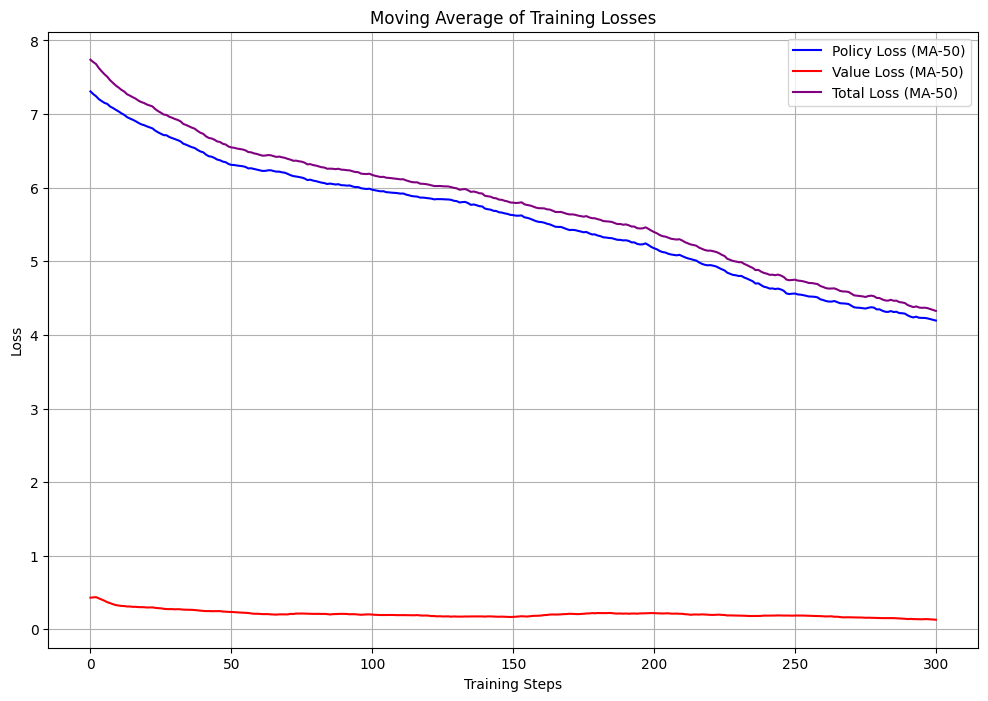

In [ ]:
model = ChessNetwork(num_res_blocks=8, num_channels=128)

# Entrenar con parámetros reducidos
trained_model = train_alphazero_optimized(
    model,
    num_iterations=7,
    games_per_iteration=10,
    epochs_per_iteration=50
)

In [ ]:
# model = train_alphazero(num_iterations=10, games_per_iteration=10)

In [ ]:
torch.save(model.state_dict(), root + 'models/chess_model_iter_10.pt')

In [ ]:
class ChessPlayer:
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu', mcts_simulations=800):
        self.model = model.to(device)
        self.device = device
        self.mcts_simulations = mcts_simulations
        self.model.eval()  # Poner el modelo en modo evaluación

    def get_move(self, board, temperature=0.1):
        """
        Obtiene el mejor movimiento según el modelo y MCTS
        """
        env = ChessEnvironment()
        env.board = board.copy()

        # Crear nodo raíz para MCTS
        root = MCTSNode(env)

        # Realizar simulaciones MCTS
        for _ in range(self.mcts_simulations):
            node = root
            search_path = [node]

            # Selección
            while not node.is_leaf() and not node.state.is_game_over():
                node = node.select_child()
                search_path.append(node)

            # Expansión y evaluación
            if not node.state.is_game_over():
                state_tensor = torch.FloatTensor(node.state._get_state()).unsqueeze(0)
                state_tensor = state_tensor.to(self.device)

                with torch.no_grad():
                    policy, value = self.model(state_tensor)
                    policy = F.softmax(policy, dim=1).squeeze(0).cpu().numpy()

                node.expand(policy)
                value = value.item()
            else:
                value = node.state._get_reward()

            # Backpropagation
            for node in reversed(search_path):
                node.update(-value)
                value = -value

        # Seleccionar el mejor movimiento
        visits = {str(action): child.visit_count
                 for action, child in root.children.items()}

        if temperature == 0:
            action = max(visits.items(), key=lambda x: x[1])[0]
        else:
            total_visits = sum(visits.values())
            probs = {action: (count/total_visits)**(1/temperature)
                    for action, count in visits.items()}
            total_probs = sum(probs.values())
            probs = {action: p/total_probs for action, p in probs.items()}
            action = np.random.choice(list(probs.keys()), p=list(probs.values()))

        return chess.Move.from_uci(action)

def play_vs_ai():
    # Cargar el modelo entrenado
    model = ChessNetwork()
    model.load_state_dict(torch.load(root + 'models/chess_model_iter_9.pt'))

    # Crear el jugador AI
    ai_player = ChessPlayer(model, mcts_simulations=800)

    # Inicializar el tablero
    board = chess.Board()

    # Preguntar al jugador qué color quiere ser
    player_color = input("¿Quieres jugar con blancas o negras? (b/n): ").lower()
    player_is_white = player_color == 'b'

    while not board.is_game_over():
        # Mostrar el tablero
        print("\n" + str(board))
        print("\nMovimientos legales:", [move.uci() for move in board.legal_moves])

        # Turno del jugador humano
        if board.turn == chess.WHITE and player_is_white or \
           board.turn == chess.BLACK and not player_is_white:
            while True:
                try:
                    move_uci = input("\nIngresa tu movimiento (en formato UCI, ej: e2e4): ")
                    move = chess.Move.from_uci(move_uci)
                    if move in board.legal_moves:
                        break
                    else:
                        print("Movimiento ilegal. Intenta de nuevo.")
                except ValueError:
                    print("Formato inválido. Usa notación UCI (ej: e2e4)")

        # Turno de la AI
        else:
            print("\nPensando...")
            move = ai_player.get_move(board)
            print(f"La AI juega: {move.uci()}")

        # Realizar el movimiento
        board.push(move)

    # Mostrar el resultado final
    print("\nJuego terminado!")
    print(board)

    if board.is_checkmate():
        winner = "Blancas" if board.turn == chess.BLACK else "Negras"
        print(f"\n¡{winner} ganan por jaque mate!")
    elif board.is_stalemate():
        print("\n¡Tablas por ahogado!")
    elif board.is_insufficient_material():
        print("\n¡Tablas por material insuficiente!")
    elif board.is_fifty_moves():
        print("\n¡Tablas por la regla de 50 movimientos!")
    elif board.is_repetition():
        print("\n¡Tablas por repetición!")

def play_ai_vs_ai(num_games=1):
    """
    Hace que la AI juegue contra sí misma
    """
    model = ChessNetwork()
    model.load_state_dict(torch.load(root + 'models/chess_model_iter_9.pt'))

    player1 = ChessPlayer(model, mcts_simulations=800)
    player2 = ChessPlayer(model, mcts_simulations=800)

    results = {'white_wins': 0, 'black_wins': 0, 'draws': 0}

    for game in range(num_games):
        print(f"\nJuego {game + 1}/{num_games}")
        board = chess.Board()

        while not board.is_game_over():
            print("\n" + str(board))

            # Seleccionar jugador
            current_player = player1 if board.turn == chess.WHITE else player2

            # Obtener y realizar movimiento
            move = current_player.get_move(board)
            print(f"Movimiento: {move.uci()}")
            board.push(move)

        # Registrar resultado
        if board.is_checkmate():
            winner = "Blancas" if board.turn == chess.BLACK else "Negras"
            if winner == "Blancas":
                results['white_wins'] += 1
            else:
                results['black_wins'] += 1
            print(f"\n¡{winner} ganan por jaque mate!")
        else:
            results['draws'] += 1
            print("\n¡Tablas!")

    # Mostrar estadísticas
    print("\nResultados finales:")
    print(f"Victorias blancas: {results['white_wins']}")
    print(f"Victorias negras: {results['black_wins']}")
    print(f"Tablas: {results['draws']}")

In [ ]:
play_vs_ai()

In [ ]:
import torch
import chess
import numpy as np

def play_against_model(model_path='chess_model_fast_iter_4.pt', mcts_simulations=150):
    """
    Función para jugar contra el modelo entrenado usando MCTS
    """
    # Cargar el modelo
    model = ChessNetwork(num_res_blocks=8, num_channels=128)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint)
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    # Inicializar el entrenador para usar MCTS
    trainer = AlphaZeroTrainer(model)
    trainer.mcts_simulations = mcts_simulations  # Ajustar número de simulaciones

    # Inicializar el tablero
    board = chess.Board()
    env = ChessEnvironment()

    # Preguntar al jugador qué color quiere ser
    color = input("¿Quieres jugar con blancas o negras? (b/n): ").lower()
    player_is_white = color.startswith('b')

    while not board.is_game_over():
        # Mostrar el estado actual
        print("\nTablero actual:")
        print(board)
        print("\nMovimientos legales:", [move.uci() for move in board.legal_moves])

        # Determinar de quién es el turno
        is_player_turn = (board.turn == chess.WHITE) == player_is_white

        if is_player_turn:
            # Turno del jugador
            while True:
                try:
                    move_str = input("\nTu movimiento (formato UCI, ejemplo 'e2e4'): ")
                    move = chess.Move.from_uci(move_str)
                    if move in board.legal_moves:
                        break
                    else:
                        print("Movimiento ilegal. Intenta de nuevo.")
                except ValueError:
                    print("Formato inválido. Usa notación UCI (ejemplo: e2e4)")
        else:
            # Turno del modelo con MCTS
            print("\nPensando...")

            # Preparar el entorno para MCTS
            env.board = board.copy()

            # Ejecutar MCTS
            root = trainer._run_single_mcts(MCTSNode(env))

            # Obtener las probabilidades de cada movimiento usando MCTS
            legal_moves = list(board.legal_moves)
            policy = trainer.get_action_prob(root, temperature=0.1)  # Temperatura baja para juego más fuerte

            # Filtrar solo movimientos legales
            legal_move_probs = np.array([
                policy[move_to_index(move, board)]
                for move in legal_moves
            ])

            # Normalizar probabilidades
            sum_probs = np.sum(legal_move_probs)
            if sum_probs > 0:
                legal_move_probs = legal_move_probs / sum_probs
            else:
                legal_move_probs = np.ones_like(legal_move_probs) / len(legal_move_probs)

            # Seleccionar el mejor movimiento
            move_idx = np.argmax(legal_move_probs)
            move = legal_moves[move_idx]

            # Mostrar información adicional sobre la decisión
            print(f"El modelo juega: {move.uci()}")
            print(f"Confianza: {legal_move_probs[move_idx]:.2%}")

            # Mostrar los 3 mejores movimientos considerados
            top_3_idx = np.argsort(legal_move_probs)[-3:][::-1]
            print("\nTop 3 movimientos considerados:")
            for idx in top_3_idx:
                print(f"{legal_moves[idx].uci()}: {legal_move_probs[idx]:.2%}")

        # Realizar el movimiento
        board.push(move)

    # Mostrar resultado final
    print("\n¡Juego terminado!")
    print(board)

    # Mostrar el resultado
    if board.is_checkmate():
        winner = "Blancas" if board.turn == chess.BLACK else "Negras"
        print(f"\n¡{winner} ganan por jaque mate!")
    elif board.is_stalemate():
        print("\n¡Tablas por ahogado!")
    elif board.is_insufficient_material():
        print("\n¡Tablas por material insuficiente!")
    elif board.is_fifty_moves():
        print("\n¡Tablas por la regla de 50 movimientos!")
    elif board.is_repetition():
        print("\n¡Tablas por repetición!")

play_against_model(root + 'models/chess_model_iter_10.pt')  # o el número de iteración que hayas alcanzado

<ipython-input-25-b77a5d862d01>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


¿Quieres jugar con blancas o negras? (b/n): n

Tablero actual:
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R

Movimientos legales: ['g1h3', 'g1f3', 'b1c3', 'b1a3', 'h2h3', 'g2g3', 'f2f3', 'e2e3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'e2e4', 'd2d4', 'c2c4', 'b2b4', 'a2a4']

Pensando...
El modelo juega: b2b3
Confianza: 99.99%

Top 3 movimientos considerados:
b2b3: 99.99%
e2e3: 0.01%
d2d3: 0.00%

Tablero actual:
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. P . . . . . .
P . P P P P P P
R N B Q K B N R

Movimientos legales: ['g8h6', 'g8f6', 'b8c6', 'b8a6', 'h7h6', 'g7g6', 'f7f6', 'e7e6', 'd7d6', 'c7c6', 'b7b6', 'a7a6', 'h7h5', 'g7g5', 'f7f5', 'e7e5', 'd7d5', 'c7c5', 'b7b5', 'a7a5']

Tu movimiento (formato UCI, ejemplo 'e2e4'): e7e5

Tablero actual:
r n b q k b n r
p p p p . p p p
. . . . . . . .
. . . . p . . .
. . . . . . . .
. P . . . . . .
P . P P P P

KeyboardInterrupt: Interrupted by user

In [ ]:
import chess
import chess.engine
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from datetime import datetime
import json
import asyncio
import torch


class EloCalculator:
    def __init__(self, alphazero_engine, reference_engines=None):
        """
        Inicializa el calculador de ELO.

        Args:
            alphazero_engine: Tu implementación de AlphaZero
            reference_engines: Lista de motores de referencia con ELO conocido
        """
        self.alphazero = alphazero_engine
        self.reference_engines = reference_engines or self._get_default_engines()
        self.results = defaultdict(list)
        self.game_records = []

    def _get_default_engines(self):
        """Define motores de referencia con ELO conocido"""
        return {
            'stockfish_1': {'path': '/usr/games/stockfish', 'elo': 1200, 'depth': 1},
            'stockfish_5': {'path': '/usr/games/stockfish', 'elo': 1600, 'depth': 5},
            'stockfish_10': {'path': '/usr/games/stockfish', 'elo': 2000, 'depth': 10},
            'stockfish_15': {'path': '/usr/games/stockfish', 'elo': 2400, 'depth': 15}
        }

    def _calculate_elo_change(self, player_elo, opponent_elo, result):
        """
        Calcula el cambio de ELO basado en el resultado.

        Args:
            player_elo: ELO actual del jugador
            opponent_elo: ELO del oponente
            result: Resultado (1 = victoria, 0.5 = tablas, 0 = derrota)
        """
        K = 32  # Factor K (ajustable)
        expected = 1 / (1 + 10 ** ((opponent_elo - player_elo) / 400))
        return K * (result - expected)

    def play_game(self, engine_config, time_control=1.0):
        """
        Juega una partida contra un motor de referencia de forma secuencial.

        Args:
            engine_config: Configuración del motor oponente
            time_control: Tiempo por movimiento en segundos
        """
        board = chess.Board()
        moves = []

        # Configura el motor de referencia
        with chess.engine.SimpleEngine.popen_uci(engine_config['path']) as engine:
            engine.configure({'Skill Level': engine_config.get('depth', 20)})

            while not board.is_game_over():
                if board.turn == chess.WHITE:
                    # Turno de AlphaZero
                    move = self.alphazero.get_best_move(board)
                else:
                    # Turno del motor de referencia
                    result = engine.play(board, chess.engine.Limit(time=time_control))
                    move = result.move

                board.push(move)
                moves.append(str(move))

            # Determina el resultado
            if board.is_checkmate():
                result = 1 if board.turn == chess.BLACK else 0
            else:
                result = 0.5

            print(result)

        return {
            'opponent': engine_config['path'],
            'opponent_elo': engine_config['elo'],
            'result': result,
            'moves': moves,
            'final_position': board.fen()
        }


    def run_tournament(self, num_games=20):
        """
        Ejecuta un torneo completo contra motores de referencia de forma lineal.

        Args:
            num_games: Número de partidas contra cada motor
        """
        for engine_name, config in self.reference_engines.items():
            print(f"Jugando contra {engine_name} (ELO {config['elo']})")

            for game_index in range(num_games):
                print(f"Partida {game_index + 1} contra {engine_name}...")
                result = self.play_game(config)
                self.game_records.append(result)
                self.results[engine_name].append(result['result'])

        print("Torneo completo.")


    def calculate_performance_rating(self):
        """Calcula el rating de rendimiento basado en los resultados."""
        total_score = 0
        total_games = 0
        weighted_elo = 0

        for engine_name, results in self.results.items():
            score = sum(results)
            games = len(results)
            opponent_elo = self.reference_engines[engine_name]['elo']

            total_score += score
            total_games += games
            weighted_elo += opponent_elo * games

        avg_opponent_elo = weighted_elo / total_games
        performance = avg_opponent_elo + 400 * ((total_score / total_games) - 0.5)

        return round(performance)

    def plot_results(self):
        """Genera gráficos de rendimiento."""
        plt.figure(figsize=(12, 6))

        engines = list(self.results.keys())
        win_rates = [sum(results) / len(results) for results in self.results.values()]

        plt.bar(engines, win_rates)
        plt.title('Tasa de Victoria contra Motores de Referencia')
        plt.ylabel('Tasa de Victoria')
        plt.ylim(0, 1)

        for i, rate in enumerate(win_rates):
            plt.text(i, rate + 0.01, f'{rate:.2%}', ha='center')

        plt.tight_layout()
        plt.savefig('elo_results.png')
        plt.close()

    def save_results(self):
        """Guarda los resultados del torneo."""
        performance_elo = self.calculate_performance_rating()

        results = {
            'timestamp': datetime.now().isoformat(),
            'performance_elo': performance_elo,
            'games_per_engine': {name: len(results)
                                 for name, results in self.results.items()},
            'win_rates': {name: sum(results)/len(results)
                          for name, results in self.results.items()},
            'game_records': self.game_records
        }

        with open('elo_evaluation.json', 'w') as f:
            json.dump(results, f, indent=2)

        return results

class AlphaZeroWrapper:
    def __init__(self, model, mcts_simulations=150, temperature=0.1):
        """
        Wrapper para usar AlphaZero en evaluación de ELO.

        Args:
            model: Modelo entrenado de la red neuronal
            mcts_simulations: Número de simulaciones MCTS
            temperature: Temperatura para selección de movimientos (más bajo = más determinista)
        """
        self.model = model
        self.mcts_simulations = mcts_simulations
        self.temperature = temperature
        self.trainer = AlphaZeroTrainer(model)  # Tu clase AlphaZeroTrainer

    def get_best_move(self, board):
        """
        Obtiene el mejor movimiento usando MCTS y la red neuronal.

        Args:
            board: Objeto chess.Board con la posición actual

        Returns:
            chess.Move: El mejor movimiento encontrado
        """
        # Crear el entorno de ajedrez desde el tablero actual
        env = ChessEnvironment()
        env.board = board.copy()

        # Ejecutar MCTS
        root = self.trainer._run_single_mcts(MCTSNode(env))

        # Obtener las probabilidades de cada movimiento
        legal_moves = env.get_legal_moves()
        policy = self.trainer.get_action_prob(root, self.temperature)

        # Obtener las probabilidades solo para movimientos legales
        legal_move_probs = np.array([
            policy[move_to_index(move, board)]
            for move in legal_moves
        ])

        # Normalizar probabilidades
        legal_move_probs = legal_move_probs / legal_move_probs.sum()

        # En evaluación, siempre elegimos el movimiento con mayor probabilidad
        best_move_idx = np.argmax(legal_move_probs)

        return legal_moves[best_move_idx]

def evaluate_alphazero_elo(model, num_games=10):
    """
    Función principal para evaluar el ELO del modelo.

    Args:
        model: Tu modelo entrenado de la red neuronal
        num_games: Número de partidas contra cada motor
    """
    # Crear el wrapper con la configuración para evaluación
    alphazero_player = AlphaZeroWrapper(
        model=model,
        mcts_simulations=150,  # Puedes ajustar según necesites
        temperature=0.1  # Temperatura baja para juego más fuerte
    )

    # Crear el calculador de ELO
    calculator = EloCalculator(alphazero_player)

    # Ejecutar el torneo
    calculator.run_tournament(num_games=num_games)

    # Generar y mostrar resultados
    calculator.plot_results()
    results = calculator.save_results()

    print(f"\nEvaluación completada:")
    print(f"ELO estimado: {results['performance_elo']}")
    for engine, rate in results['win_rates'].items():
        print(f"Tasa de victoria contra {engine}: {rate:.2%}")

    return results

# Cargar tu modelo entrenado
model = ChessNetwork(num_res_blocks=8, num_channels=128)
model.load_state_dict(torch.load(root + 'models/chess_model_iter_10.pt'))
model.eval()  # Poner en modo evaluación

# Ejecutar la evaluación
results = evaluate_alphazero_elo(
    model=model
)

<ipython-input-31-be4354547520>:255: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(root + 'models/chess_model_iter_10.pt'))


Jugando contra stockfish_1 (ELO 1200)
Partida 1 contra stockfish_1...
0
Partida 2 contra stockfish_1...
0
Partida 3 contra stockfish_1...
0
Partida 4 contra stockfish_1...
0
Partida 5 contra stockfish_1...
0
Partida 6 contra stockfish_1...
0
Partida 7 contra stockfish_1...
0
Partida 8 contra stockfish_1...
0
Partida 9 contra stockfish_1...
0
Partida 10 contra stockfish_1...
0
Jugando contra stockfish_5 (ELO 1600)
Partida 1 contra stockfish_5...
0
Partida 2 contra stockfish_5...
0
Partida 3 contra stockfish_5...
0
Partida 4 contra stockfish_5...
0
Partida 5 contra stockfish_5...
0
Partida 6 contra stockfish_5...
0
Partida 7 contra stockfish_5...
0
Partida 8 contra stockfish_5...
0
Partida 9 contra stockfish_5...
0
Partida 10 contra stockfish_5...
0
Jugando contra stockfish_10 (ELO 2000)
Partida 1 contra stockfish_10...
0
Partida 2 contra stockfish_10...
0
Partida 3 contra stockfish_10...
0
Partida 4 contra stockfish_10...
0
Partida 5 contra stockfish_10...
0
Partida 6 contra stockfish_1

In [ ]:
def calculate_model_elo(results, initial_elo=1000, k=50):
    """
    Calcula el ELO del modelo basado en los resultados de las partidas.

    Args:
        results (list of dict): Lista de resultados, cada uno con las claves:
            - 'opponent_elo': ELO del oponente.
            - 'result': Resultado de la partida (1 = victoria, 0.5 = tablas, 0 = derrota).
        initial_elo (int): ELO inicial del modelo.
        k (int): Factor K para el cálculo de ELO.

    Returns:
        float: ELO final del modelo.
    """
    model_elo = initial_elo

    for game in results:
        opponent_elo = game['opponent_elo']
        result = game['result']

        # Calcular resultado esperado
        expected = 1 / (1 + 10 ** ((opponent_elo - model_elo) / 400))

        # Actualizar ELO del modelo
        model_elo += k * (result - expected)

    return model_elo

In [ ]:
model_elo = calculate_model_elo(results['game_records'])
print(f"ELO final del modelo: {model_elo}")

ELO final del modelo: 892.8381134068632
